# Generate LOWO-CV YAC RFCDE Summary

## Purpose

The purpose of this notebook is to evaluate the YAC RFCDE model out-of-sample based on different sets of features. This notebook results in a table containing a summary of the out-of-sample performance which will then be visualized in a separate R script.

### Check for necessary packages

The following code chunk checks to see if the necessary packages are installed, and if not - installs them:

In [3]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing:
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'numpy', 'pandas', 'rfcde', 'cdetools'}
missing_packages = required_packages - installed_packages

# If there are missing packages install:
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout = subprocess.DEVNULL)

## Load the data

Read in the modeling dataset that was constructed via `R`:

In [4]:
import numpy as np
import pandas as pd
import os
os.chdir('/Users/ronaldyurko/Documents/Evaluating-YAC-Defense-with-Ghosting/')
model_data = pd.read_csv('data/model_datasets/at_catch_yac_model_data.csv.gz')

In [5]:
model_data

,week_id,game_play_id,end_x_change,adj_bc_x,adj_bc_y,bc_s,bc_dir_target_endzone,bc_o_target_endzone,adj_bc_x_from_first_down,adj_qb_x,...,offense_4_o_target_endzone_absval,qb_adj_y_change_absval,defense_1_adj_y_change_absval,defense_2_adj_y_change_absval,defense_3_adj_y_change_absval,defense_4_adj_y_change_absval,offense_1_adj_y_change_absval,offense_2_adj_y_change_absval,offense_3_adj_y_change_absval,offense_4_adj_y_change_absval
0,1,2018090600_75,1.39,71.48,-23.463333,4.93,-88.86,-56.77,6.48,86.43,...,132.74,18.13,1.05,0.80,11.12,12.20,13.53,19.14,22.31,36.82
1,1,2018090600_190,5.99,12.84,17.966667,7.57,41.70,104.85,-16.16,48.11,...,4.10,5.45,0.12,3.77,3.26,16.44,1.36,17.14,17.19,16.20
2,1,2018090600_320,-3.00,93.07,22.753333,6.92,110.75,161.60,5.07,102.21,...,132.98,11.18,0.32,7.20,11.07,15.00,7.49,19.05,18.33,31.00
3,1,2018090600_492,32.08,41.39,18.096667,5.87,23.31,8.17,18.39,46.95,...,167.99,11.10,6.71,12.00,13.31,11.99,14.09,16.01,13.91,26.17
4,1,2018090600_521,0.44,6.83,8.656667,4.60,57.34,126.99,6.83,18.50,...,125.10,3.84,1.52,6.08,8.88,0.21,4.84,10.34,3.99,4.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10460,17,2018123011_3588,0.87,34.68,19.833333,6.55,79.55,26.61,6.68,44.56,...,30.13,5.70,0.20,13.66,9.46,13.78,1.72,14.11,11.40,19.60
10461,17,2018123011_3613,3.75,33.04,21.693333,3.95,79.46,-130.82,5.04,40.85,...,95.18,10.10,0.34,7.09,11.50,18.12,10.32,13.90,16.90,36.58
10462,17,2018123011_3883,3.36,82.75,22.926667,5.13,35.09,5.95,5.75,96.92,...,58.11,12.95,0.93,5.55,3.54,13.41,4.27,17.80,19.13,23.67
10463,17,2018123011_3947,7.73,85.91,-0.173333,2.78,18.31,18.77,8.91,96.89,...,68.04,2.64,1.77,3.92,1.79,7.08,3.77,3.71,3.33,22.91


## Perform LOWO-CV analysis

To aid in this process, we'll first initialize a helper function to generate the LOWO-CV results for a given dataset, where the only variables provided are the `week_id`, the response variable `end_x_change`, and the considered predictor variables. This way we can just apply this function to each set of considered features for comparison purposes.

In [6]:
import rfcde
from cdetools.cde_loss import cde_loss

# Set-up grid parameters
RF_BW = "normal_reference"
MIN_GAIN = np.round(model_data.end_x_change.min())
MAX_GAIN = np.round(model_data.adj_bc_x.max())

def get_lowo_cv_results(model_dataset, x_features,
                        delta_yards = 0.5, min_gain = MIN_GAIN, max_gain = MAX_GAIN, 
                        padding = 2, rf_bw = RF_BW):
    
    # Only keep rows without any NA values:
    model_dataset = model_dataset.dropna()
    
    
    # Init the dict to store the results to return:
    results = []

    # Loop through each holdout week:
    for test_week in model_dataset.week_id.unique():
        
        # Split the data into training and test data:
        train_data = model_dataset.loc[model_dataset.week_id != test_week]
        test_data = model_dataset.loc[model_dataset.week_id == test_week]
        
        train_x = train_data.loc[:, x_features].values
        train_y = train_data.loc[:, 'end_x_change'].values
        test_x = test_data.loc[:, x_features].values
        test_y = test_data.loc[:, 'end_x_change'].values
        
        # Train the model:
        train_forest = rfcde.RFCDE(n_trees = 500, mtry = np.floor(np.sqrt(train_x.shape[1])),
                                   n_basis = 30, node_size = 5)
        train_forest.train(train_x, train_y)
        
        # Set-up the grid:
        cde_grid = np.arange(min_gain, max_gain + padding + delta_yards, delta_yards)
        
        # Get the test data CDE predictions:
        cde_test = train_forest.predict(test_x, cde_grid, rf_bw)
        
        # Get the performance metrics:
        cde_loss_val, std_cde_loss = cde_loss(cde_test, cde_grid, test_y)
        cde_test_mean = train_forest.predict_mean(test_x)
        cde_test_mode = cde_grid[np.argmax(cde_test, axis = 1)]
        
        results.append({'test_week': test_week, 
                        'cde_loss_val': cde_loss_val,
                        'cde_test_mean_rmse': np.sqrt(np.mean((cde_test_mean - test_y)**2)),
                        'cde_test_mode_rmse': np.sqrt(np.mean((cde_test_mode - test_y)**2))})
    
    return pd.DataFrame(results)

    

Initialize the different sets of feature vectors to generate the results with:

In [13]:
# Ball-carrier and QB related information:
bc_qb_vars = ["adj_bc_x", "adj_bc_y", "bc_s", "bc_dir_target_endzone_absval", "bc_o_target_endzone_absval",
              "adj_bc_x_from_first_down", "qb_adj_x_change", "qb_adj_y_change_absval", "qb_dist_to_bc", "qb_s"]

# Set-up the vector for each defense features:
def_1_vars = [col for col in model_data.columns if (col.startswith('defense_1') and 
                                                    col not in ['defense_1_adj_y_change',
                                                                'defense_1_dir_target_endzone',
                                                                'defense_1_o_target_endzone'])]
def_2_vars = [col for col in model_data.columns if (col.startswith('defense_2') and 
                                                    col not in ['defense_2_adj_y_change',
                                                                'defense_2_dir_target_endzone',
                                                                'defense_2_o_target_endzone'])]
def_3_vars = [col for col in model_data.columns if (col.startswith('defense_3') and 
                                                    col not in ['defense_3_adj_y_change',
                                                                'defense_3_dir_target_endzone',
                                                                'defense_3_o_target_endzone'])]
def_4_vars = [col for col in model_data.columns if (col.startswith('defense_4') and 
                                                    col not in ['defense_4_adj_y_change',
                                                                'defense_4_dir_target_endzone',
                                                                'defense_4_o_target_endzone'])]

# Set-up the vector for each offense features:
off_1_vars = [col for col in model_data.columns if (col.startswith('offense_1') and 
                                                    col not in ['offense_1_adj_y_change',
                                                                'offense_1_dir_target_endzone',
                                                                'offense_1_o_target_endzone'])]
off_2_vars = [col for col in model_data.columns if (col.startswith('offense_2') and 
                                                    col not in ['offense_2_adj_y_change',
                                                                'offense_2_dir_target_endzone',
                                                                'offense_2_o_target_endzone'])]
off_3_vars = [col for col in model_data.columns if (col.startswith('offense_3') and 
                                                    col not in ['offense_3_adj_y_change',
                                                                'offense_3_dir_target_endzone',
                                                                'offense_3_o_target_endzone'])]
off_4_vars = [col for col in model_data.columns if (col.startswith('offense_4') and 
                                                    col not in ['offense_4_adj_y_change',
                                                                'offense_4_dir_target_endzone',
                                                                'offense_4_o_target_endzone'])]

# Now combine for different combinations of interest:
bc_qb_def1_vars = bc_qb_vars + def_1_vars
bc_qb_def12_vars = bc_qb_def1_vars + def_2_vars

# Include offense?:
bc_qb_def1_off1_vars = bc_qb_def1_vars + off_1_vars
bc_qb_def12_off12_vars = bc_qb_def12_vars + off_2_vars

And now generate the RFCDE LOWO-CV results for the different sets of variables

In [15]:
bc_qb_rfcde = get_lowo_cv_results(model_data, bc_qb_vars)

In [25]:
bc_qb_rfcde['features'] = "bc_qb_only"

In [18]:
bc_qb_def1_rfcde = get_lowo_cv_results(model_data, bc_qb_def1_vars)

In [27]:
bc_qb_def1_rfcde['features'] = "bc_qb_def1"

In [21]:
bc_qb_def12_rfcde = get_lowo_cv_results(model_data, bc_qb_def12_vars)

In [28]:
bc_qb_def12_rfcde['features'] = "bc_qb_def12"

In [22]:
bc_qb_def1_off1_rfcde = get_lowo_cv_results(model_data, bc_qb_def1_off1_vars)

In [29]:
bc_qb_def1_off1_rfcde['features'] = "bc_qb_def1_off1"

In [23]:
bc_qb_def12_off12_rfcde = get_lowo_cv_results(model_data, bc_qb_def12_off12_vars)

In [30]:
bc_qb_def12_off12_rfcde['features'] = "bc_qb_def12_off12"

In [32]:
rfcde_lowo_cv_results =  pd.concat([bc_qb_rfcde, bc_qb_def1_rfcde, bc_qb_def12_rfcde,
                                    bc_qb_def1_off1_rfcde, bc_qb_def12_off12_rfcde])

In [33]:
rfcde_lowo_cv_results

,test_week,cde_loss_val,cde_test_mean_rmse,cde_test_mode_rmse,features
0,1,-0.152832,5.975083,6.723482,bc_qb_only
1,2,-0.134649,6.257746,7.164122,bc_qb_only
2,3,-0.126045,5.909852,6.863134,bc_qb_only
3,4,-0.120047,6.159391,7.130966,bc_qb_only
4,5,-0.135171,6.284115,7.253386,bc_qb_only
...,...,...,...,...,...
12,13,-0.168338,5.073779,5.598013,bc_qb_def12_off12
13,14,-0.158442,6.324389,6.836172,bc_qb_def12_off12
14,15,-0.154644,4.767438,5.408234,bc_qb_def12_off12
15,16,-0.163602,5.036392,5.767906,bc_qb_def12_off12


And finally save the results:

In [34]:
rfcde_lowo_cv_results.to_csv('data/yac_model_output/lowo_validation/rfcde_feature_comparison.csv')

## Extra

Following was extra code when attempting to visualize the CDE with observed values

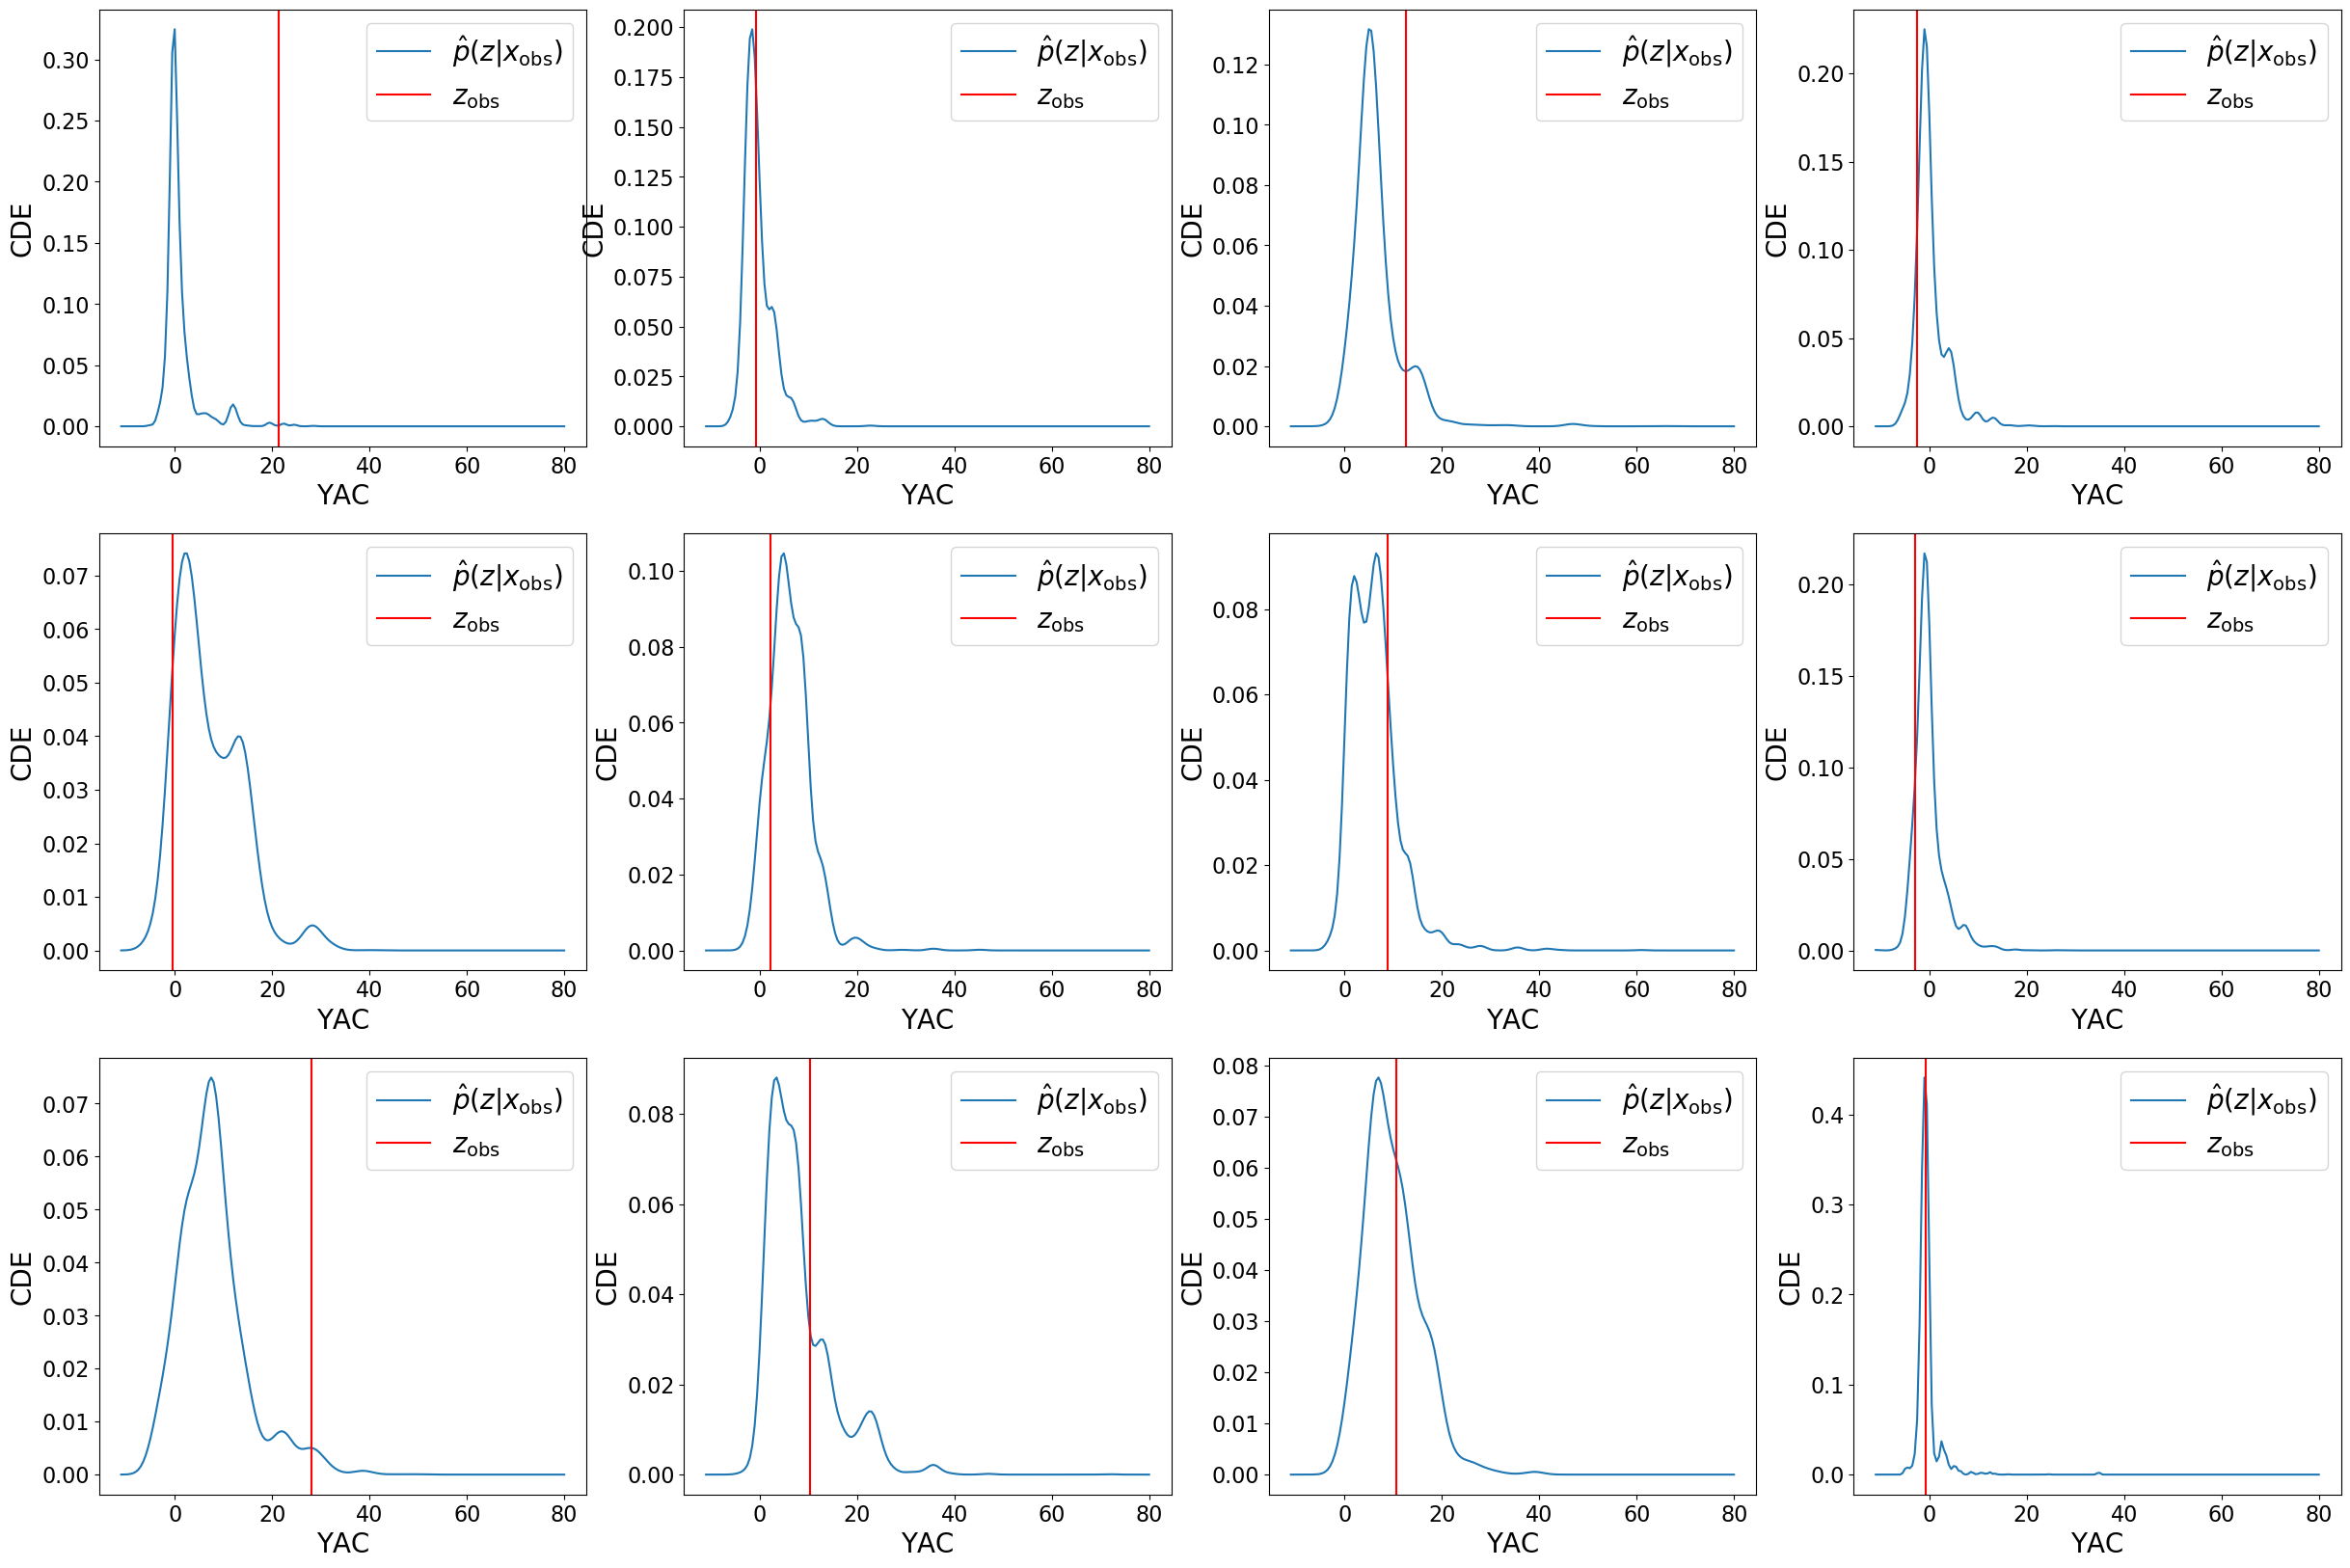

In [52]:
from cdetools.cde_loss import cde_loss
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(30, 20))
for jj, cde_predicted in enumerate(test_density[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(TEST_GRID, cde_predicted, label=r'$\hat{p}(z| x_{\rm obs})$')
    plt.axvline(test_y[jj], color='red', label=r'$z_{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'YAC', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 20})
plt.show()